
# Analiza anizotropii i specyficzności kontekstowej modeli BERT i GPT-2 dla języka polskiego

### Opis zadania
W niniejszym notatniku przeprowadzimy analizę anizotropii (anisotropy) oraz specyficzności kontekstowej (context-specificity) na reprezentacjach wygenerowanych przez modele BERT i GPT-2 dla języka polskiego.

### Kroki:
1. Załadujemy zbiór danych z `Hugging Face`.
2. Załadujemy modele BERT i GPT-2.
3. Przeprowadzimy analizę anizotropii.
4. Przeprowadzimy analizę specyficzności kontekstowej.

### Wymagania
Przed uruchomieniem notatnika należy zainstalować wymagane pakiety:
```bash
pip install transformers torch datasets scipy numpy
```


In [1]:

import torch
import numpy as np
import scipy
from transformers import AutoModel, AutoTokenizer
from datasets import load_dataset
from scipy.spatial.distance import cosine


c:\Users\jkoro\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



## Załadowanie zbioru danych oraz modeli
W tej sekcji załadujemy zbiór danych oraz dwa modele: BERT (`polish-roberta`) oraz GPT-2 (`polish-gpt2`).


In [ ]:

# Załaduj zbiór danych
dataset = load_dataset("clarin-knext/wsd_polish_datasets", split="train", trust_remote_code=True)


c:\Users\jkoro\AppData\Local\Programs\Python\Python39\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jkoro\.cache\huggingface\hub\models--sdadas--polish-gpt2-medium. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [48]:

from transformers import AutoModel, AutoTokenizer

bert_model = AutoModel.from_pretrained("bert-base-uncased", output_hidden_states=True)
gpt2_model = AutoModel.from_pretrained("gpt2", output_hidden_states=True)

# Załaduj modele
bert_model_name = "bert-base-uncased"
gpt2_model_name = "gpt2"

bert_model = AutoModel.from_pretrained(bert_model_name, output_hidden_states=True)
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)

gpt2_model = AutoModel.from_pretrained(gpt2_model_name, output_hidden_states=True)
gpt2_tokenizer = AutoTokenizer.from_pretrained(gpt2_model_name)

# Ustawienie pad_token dla GPT-2
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token



## Przygotowanie danych
Przetwarzamy teksty ze zbioru danych, aby były gotowe do analizy. W tej sekcji będziemy ekstraktować reprezentacje tokenów z modeli.


In [49]:

def get_layer_embeddings(model, tokenizer, texts, max_length=512):
    embeddings = []
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=max_length)
        with torch.no_grad():
            outputs = model(**inputs)
        hidden_states = outputs.hidden_states
        embeddings.append(hidden_states)
    return embeddings

# Przykładowe teksty z danych
sample_texts = dataset["text"][:100]
bert_embeddings = get_layer_embeddings(bert_model, bert_tokenizer, sample_texts)
gpt2_embeddings = get_layer_embeddings(gpt2_model, gpt2_tokenizer, sample_texts)


In [50]:
from sklearn.metrics.pairwise import cosine_similarity


# Funkcja do obliczania średniego kosinusowego podobieństwa losowo wybranych słów
def average_cosine_similarity(embeddings, num_layers=12):
    similarities = []
    for layer in range(1, num_layers + 1):
        layer_embeddings = [e[layer].squeeze().numpy() for e in embeddings]
        random_samples = [emb[np.random.choice(range(len(emb)), 2, replace=False)] for emb in layer_embeddings]
        layer_similarities = [cosine_similarity(sample[0].reshape(1, -1), sample[1].reshape(1, -1))[0, 0] for sample in random_samples]
        similarities.append(np.mean(layer_similarities))
    return similarities

# Funkcja do obliczania średniego podobieństwa wewnątrz zdania
def intra_sentence_similarity(embeddings, num_layers=12):
    similarities = []
    for layer in range(1, num_layers + 1):
        layer_embeddings = [e[layer].squeeze().numpy() for e in embeddings]
        sentence_similarities = [cosine_similarity(emb).mean() for emb in layer_embeddings]
        similarities.append(np.mean(sentence_similarities))
    return similarities

In [51]:

# Obliczanie średnich kosinusowych podobieństw
bert_avg_cosine_sim = average_cosine_similarity(bert_embeddings)
gpt2_avg_cosine_sim = average_cosine_similarity(gpt2_embeddings)


In [52]:

# Obliczanie średnich podobieństw wewnątrz zdania
bert_intra_sentence_sim = intra_sentence_similarity(bert_embeddings)
gpt2_intra_sentence_sim = intra_sentence_similarity(gpt2_embeddings)


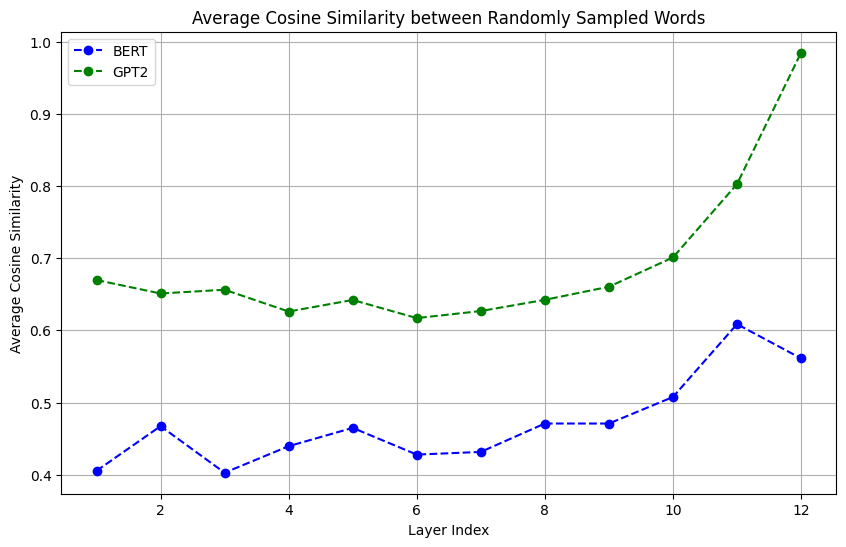

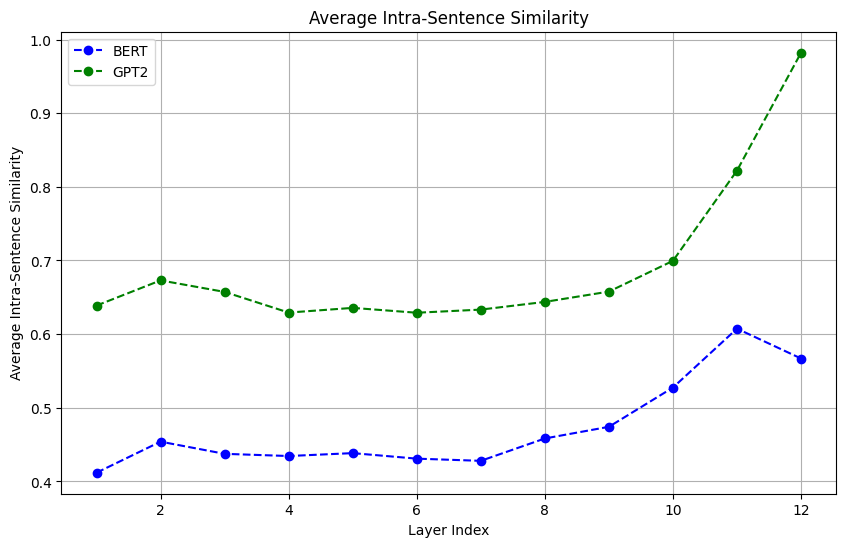

In [53]:
import matplotlib.pyplot as plt

# Tworzenie wykresu średniej kosinusowej podobieństwa
layers = list(range(1, 13))
plt.figure(figsize=(10, 6))
plt.plot(layers, bert_avg_cosine_sim, 'bo--', label='BERT')
plt.plot(layers, gpt2_avg_cosine_sim, 'go--', label='GPT2')
plt.xlabel("Layer Index")
plt.ylabel("Average Cosine Similarity")
plt.title("Average Cosine Similarity between Randomly Sampled Words")
plt.legend()
plt.grid()
plt.show()

# Tworzenie wykresu średniego podobieństwa wewnątrz zdania
plt.figure(figsize=(10, 6))
plt.plot(layers, bert_intra_sentence_sim, 'bo--', label='BERT')
plt.plot(layers, gpt2_intra_sentence_sim, 'go--', label='GPT2')
plt.xlabel("Layer Index")
plt.ylabel("Average Intra-Sentence Similarity")
plt.title("Average Intra-Sentence Similarity")
plt.legend()
plt.grid()
plt.show()